In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import glob 

plt.ion()   # interactive mode

In [2]:
import pandas as pd

data_dir = '../UCMerced_LandUse/Images_old/'

df = pd.read_excel ('./multilabels/LandUse_Multilabeled.xlsx')
df_label = np.array(df)

In [3]:
from torch.utils.data import Dataset
from natsort import natsorted

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform, labelmat):
        self.main_dir = main_dir
        self.transforms = transform
        self.all_imgs = glob.glob(os.path.join(main_dir, '**/*.tif'), recursive=True)
        self.total_imgs = natsorted(self.all_imgs)
        self.xlabels = labelmat
        
    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        #print(idx,len(self.total_imgs))
        img_loc = self.total_imgs[idx]
        imagebaselabel = os.path.splitext(os.path.basename(img_loc))[0]
        ### find the corresponding image in the label matrix
        label = self.xlabels[np.where(self.xlabels[:,0] == imagebaselabel),1:].reshape(17).astype(np.int64)
        tensor_label =  torch.from_numpy(label)
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transforms(image)
        return tensor_image, tensor_label

In [4]:
def load_split_train_test(datadir, labelmat,valid_size = .2):
    train_transforms = transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    
    indices = list(range(2100))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    #train_sampler = SubsetRandomSampler(indices)
    

    train_data = CustomDataSet(datadir, transform=train_transforms, labelmat=labelmat)

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=1)
    
    train_data_sl = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    
    trainloader_sl = torch.utils.data.DataLoader(train_data_sl,batch_size=1)

    
    return {'train_ml': train_data, 'train_sl': train_data_sl}, trainloader_sl.dataset.classes
dataloaders, class_names_old = load_split_train_test(data_dir, df_label)
#class_names = dataloaders['train'].dataset.classes
class_names =  np.array(["airplane","bare-soil","buildings","cars","chaparral","court","dock","field","grass","mobile-home","pavement","sand","sea","ship","tanks","trees","water"])
#class_names_old = dataloaders['train_sl'].dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
import sys
sys.path.append("./Federated-Learning-for-Remote-Sensing/")
from cnn_nets import LENET, RESNET34, ALEXNET

def load_split_train_test(datadir, labelmat,valid_size = .2):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_data = CustomDataSet(datadir, transform=train_transforms, labelmat=labelmat)
    test_data = CustomDataSet(datadir, transform=train_transforms, labelmat=labelmat)

    indices = list(range(2100))
    split = int(np.floor(valid_size * 2100))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=4)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=4) 
    return {'train': trainloader, 'val': testloader}, {'train': len(train_idx), 'val':len(test_idx)}
dataloaders ,dataset_sizes = load_split_train_test(data_dir, df_label,.2)
print(dataset_sizes)
#class_names = dataloaders['train'].dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 1680, 'val': 420}


In [6]:
from sklearn.metrics import f1_score, accuracy_score

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(8,30))
    rowindx = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = np.heaviside(outputs.cpu().detach().numpy(),0)
            print("preds:\n ", preds,"\n true:\n ", labels.data.to("cpu").numpy())
            print("f1 score:", f1_score(preds,labels.data.to("cpu").numpy(), average="samples"))
            print("accuracy:", ((torch.sum(torch.from_numpy(preds).to(device)
                                            == labels.data)).item() / 17)/4)

            #_, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//2, 2, images_so_far)
                #axs[rowindx, images_so_far%4].axis('off')
                #ax.set_title(f'it is {class_names[labels[j]]} and resnet predicted: {class_names[preds[j]]}')
                axs[rowindx].set_title(f'True label {class_names[labels[j].cpu().numpy() > 0].tolist()}\n Predicted:{class_names[preds[j] > 0].tolist()}', fontsize=12)
                #axs[rowindx].set_title(f'Predicted:{class_names[preds[j] > 0].tolist()}', fontsize=12)
                #imshow(inputs.cpu().data[j])
                
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                axs[rowindx].imshow(inp)
                
                axs[rowindx].set_yticks([])
                axs[rowindx].set_xticks([])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                rowindx +=1
        model.train(mode=was_training)

preds:
  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]] 
 true:
  [[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
 [0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0]]
f1 score: 0.8809523809523809
accuracy: 0.9705882352941176
preds:
  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.]] 
 true:
  [[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0]]
f1 score: 1.0
accuracy: 1.0


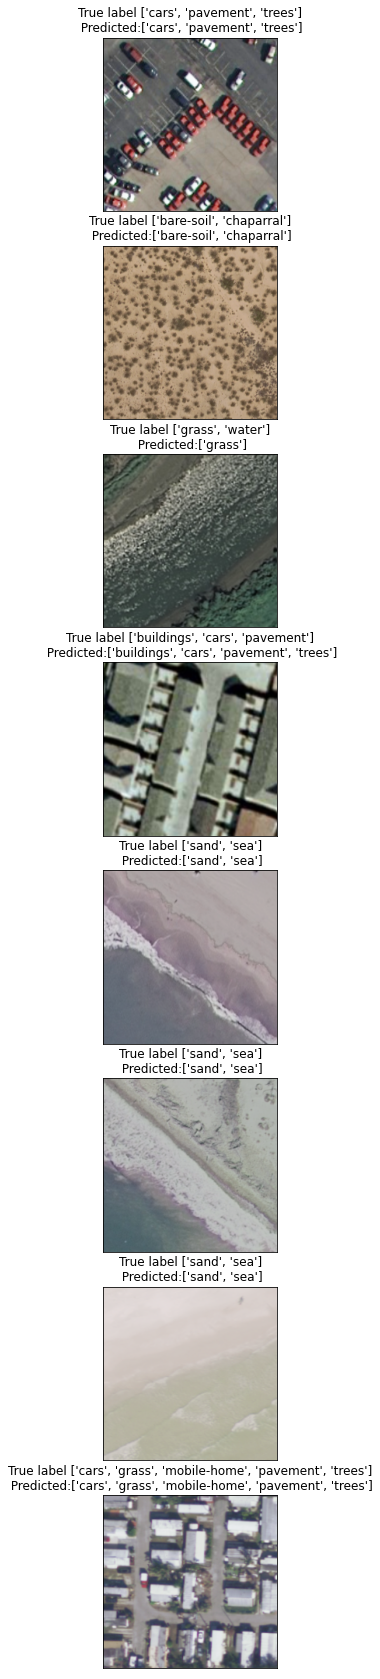

In [7]:
model = torch.load("./latest_FedAvg_lenet_with_4_clients_40_clientsepox_5_vsplit_0.2_lr_0.001.pt")
visualize_model(model, 8)